In [24]:
""" Compute SHAP Shapley value estimates for a given simulation. """

import copy
import json
import re

import pandas as pd
import shap

from pheno_sim.shap import SHAPWrapper


def run_SHAP(
	simulation,
	phenotype: str,
	collapse_haplotypes=False,
	save_path=None,
	save_config_path=None,
):
	"""Runs SHAP Shapley value estimation for a given simulation.
	
	Data is read from genotype data files defined in the simulation object.

	Returns a DataFrame and optionally saves it to a CSV file if save_path
	is not None. The DataFrame contains a 'sample_id' column and:
		if collapse_haplotypes is True, one column for each input loci.
		if collapse_haplotypes is False, two columns for each input loci.

	Args:
		simulation (PhenoSimulation): PhenoSimulation object.
		phenotype (str): Phenotype key to use for SHAP values.
		collapse_haplotypes (bool, optional): Whether to collapse haplotypes
			into a single value. Defaults to True.
		save_path (str, optional): Path to save DataFrame to. Defaults to None.
			If None, DataFrame is not saved.
		save_config_path (str, optional): Path to save simulation config to.
			Useful if simulation config contains random elements (like
			RandomConstants) that had not yet been drawn. Defaults to None,
			which does not save simulation config.
	"""

	# Get input data
	input_df = simulation.vals_dict_to_dataframe(
		simulation.run_input_step()
	)

	# Create SHAP wrapper
	shap_wrapper = SHAPWrapper(simulation, 'phenotype', input_df.columns)

	# Create SHAP explainer
	explainer = shap.Explainer(
		shap_wrapper,
		input_df,
		algorithm='permutation',
		# algorithm='partition',
	)

	# Calculate SHAP values
	shap_values = explainer(input_df)

	# Create DataFrame from SHAP values
	shap_values = pd.DataFrame(
		shap_values.values,
		columns=input_df.columns,
	)

	# Collapse haplotypes if desired
	if collapse_haplotypes:
		collapsed_name_map = {}
		for col in shap_values.columns:
			col_name_parts = col.split('*-*')
			key = col_name_parts[0]

			if len(col_name_parts) == 1:				
				collapsed_name_map[key] = [col]
			elif len(col_name_parts) == 2:
				if col_name_parts[1] == 'a' or col_name_parts[1] == 'b':
					if key not in collapsed_name_map:
						collapsed_name_map[key] = [col]
					collapsed_name_map[key].append(col)
				else:
					key = col
					collapsed_name_map[key] = [col]
			elif len(col_name_parts) == 3:
				if col_name_parts[1] == 'a' or col_name_parts[1] == 'b':
					key = col_name_parts[0] + '*-*' + col_name_parts[2]
					if key not in collapsed_name_map:
						collapsed_name_map[key] = [col]
					collapsed_name_map[key].append(col)
				else:
					raise ValueError(
						'Invalid column name: {}'.format(col)
					)
			else:
				raise ValueError(
					'Invalid column name: {}'.format(col)
				)

		# Collapse haplotypes
		for key, cols in collapsed_name_map.items():
			if len(cols) > 1:
				shap_values[key] = shap_values[cols].sum(axis=1)
				output = shap_values.drop(columns=cols)


	# Add sample IDs
	shap_values['sample_id'] = simulation.sample_ids

	# Save SHAP values
	if save_path is not None:
		shap_values.to_csv(save_path, index=False)

	# Save simulation config
	if save_config_path is not None:
		with open(save_config_path, 'w') as f:
			json.dump(simulation.get_config(), f, indent=4)
		
	return shap_values, explainer


if __name__ == '__main__':
	""" Example of what CL script would look like. """

	from pheno_sim import PhenoSimulation

	sim_config_path = 'test_configs/simple_sim.json'
	phenotype_key = 'phenotype'

	# This would be different for CL to allow for passing
	# genotype files as args. See run_simulation.py for example.
	simulation = PhenoSimulation.from_JSON_file(sim_config_path)

	output = run_SHAP(
		simulation,
		phenotype_key,
		# save_path='test_shap.csv',
		# save_config_path='test_shap_config.json',
	)

	print(output)
	print(type(output))


	# shap.summary_plot(output)
	print(output.shape)

	



Loading input data...


Permutation explainer: 2505it [02:12, 17.52it/s]                                      


(      LDLR_upstream_variant*-*a  LDLR_upstream_variant*-*b  \
0                         -0.01                     -0.012   
1                         -0.01                     -0.012   
2                         -0.01                     -0.012   
3                         -0.01                     -0.012   
4                         -0.01                     -0.012   
...                         ...                        ...   
2499                      -0.01                     -0.012   
2500                      -0.01                      0.088   
2501                      -0.01                     -0.012   
2502                      -0.01                     -0.012   
2503                      -0.01                     -0.012   

      LDLR_intron_A_variants*-*a*-*0  LDLR_intron_A_variants*-*a*-*1  \
0                           0.041977                       -0.039198   
1                           0.041977                       -0.039198   
2                           0.041977  

AttributeError: 'tuple' object has no attribute 'shape'

In [28]:
vals, explainer = output

In [29]:
type(vals)

pandas.core.frame.DataFrame

In [30]:
import numpy as np

In [31]:
vals

,LDLR_upstream_variant*-*a,LDLR_upstream_variant*-*b,LDLR_intron_A_variants*-*a*-*0,LDLR_intron_A_variants*-*a*-*1,LDLR_intron_A_variants*-*b*-*0,LDLR_intron_A_variants*-*b*-*1,LDLR_intron_B_variant*-*a,LDLR_intron_B_variant*-*b,LDLR_missense_variants*-*a*-*0,LDLR_missense_variants*-*a*-*1,LDLR_missense_variants*-*b*-*0,LDLR_missense_variants*-*b*-*1,sample_id
0,-0.01,-0.012,0.041977,-0.039198,0.050373,-0.038534,-0.002071,-0.002260,-0.014073,-0.005267,-0.023456,-0.021066,HG00096
1,-0.01,-0.012,0.041977,-0.039198,0.050373,0.027904,0.001067,0.000879,-0.014073,-0.005267,-0.023456,-0.021066,HG00097
2,-0.01,-0.012,0.041977,0.027239,0.050373,-0.038534,0.001067,-0.002260,-0.014073,-0.005267,-0.023456,-0.021066,HG00099
3,-0.01,-0.012,0.041977,-0.039198,0.050373,-0.038534,-0.002071,-0.002260,-0.014073,-0.005267,-0.023456,-0.021066,HG00100
4,-0.01,-0.012,0.041977,-0.039198,0.050373,0.027904,-0.002071,0.000879,-0.014073,-0.005267,-0.023456,-0.021066,HG00101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,-0.01,-0.012,0.041977,0.027239,0.050373,0.027904,0.001067,0.000879,-0.014073,-0.005267,-0.023456,-0.021066,NA21137
2500,-0.01,0.088,0.041977,-0.039198,-0.369401,0.027904,-0.002071,0.000879,-0.014073,-0.005267,-0.023456,-0.021066,NA21141
2501,-0.01,-0.012,0.041977,-0.039198,0.050373,-0.038534,-0.002071,-0.002260,-0.014073,-0.005267,-0.023456,-0.021066,NA21142
2502,-0.01,-0.012,0.041977,0.027239,0.050373,0.027904,0.001067,0.000879,-0.014073,-0.005267,-0.023456,-0.021066,NA21143


In [33]:
feature_names = list(vals.columns.values)

In [34]:
len(feature_names)

13

In [36]:
np.array(vals)[:, :-1]

array([[-0.01, -0.012000000000000002, 0.0419774411541557, ...,
        -0.0052665579563691296, -0.02345566369967465,
        -0.021066231825476518],
       [-0.01, -0.012000000000000007, 0.041977441154155755, ...,
        -0.005266557956369136, -0.02345566369967467,
        -0.021066231825476518],
       [-0.009999999999999998, -0.012000000000000002,
        0.041977441154155706, ..., -0.005266557956369132,
        -0.02345566369967465, -0.021066231825476518],
       ...,
       [-0.010000000000000004, -0.012000000000000004,
        0.041977441154155734, ..., -0.0052665579563691296,
        -0.02345566369967466, -0.021066231825476515],
       [-0.010000000000000012, -0.012000000000000014,
        0.04197744115415578, ..., -0.00526655795636914,
        -0.023455663699674688, -0.021066231825476515],
       [-0.010000000000000005, -0.012, 0.04197744115415574, ...,
        -0.0052665579563691296, -0.02345566369967467,
        -0.021066231825476515]], dtype=object)

In [37]:
shap_values = np.array(vals)[:, :-1].astype(float)

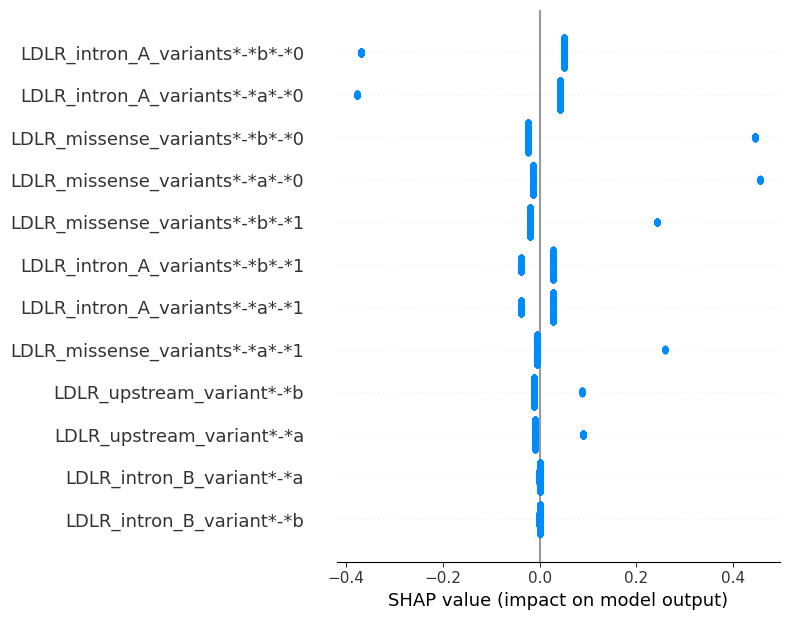

In [38]:
shap.summary_plot(shap_values, feature_names=feature_names)

In [39]:
shap_values.shape

(2504, 12)

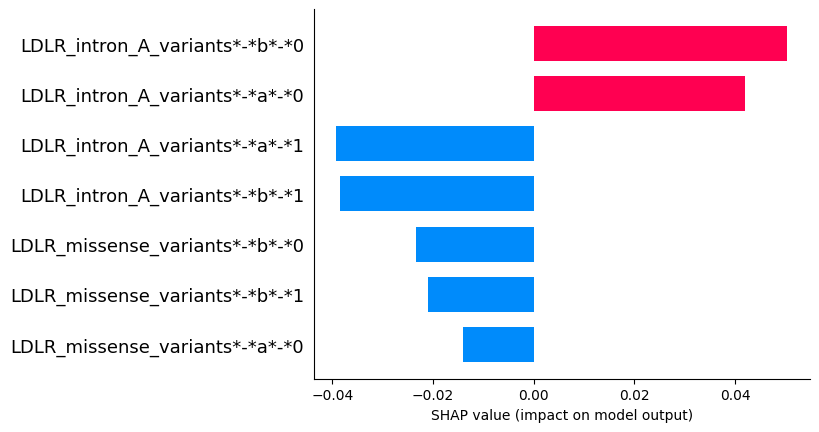

In [40]:
shap.bar_plot(shap_values[0], feature_names=feature_names)

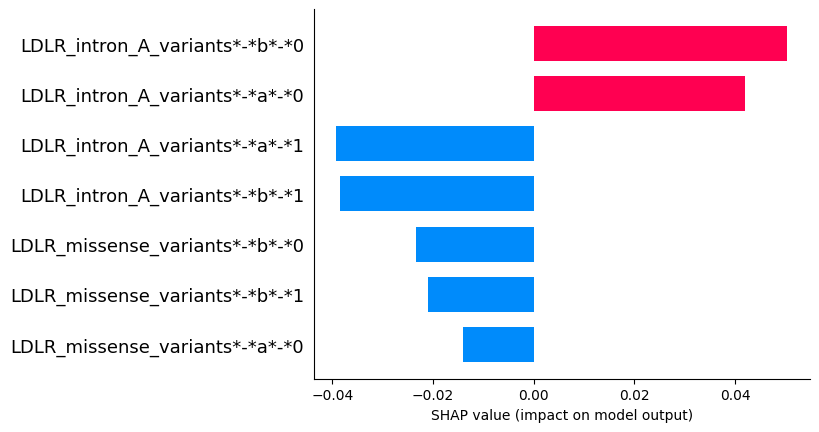

In [43]:
shap.bar_plot(shap_values[0], feature_names=feature_names) 

In [45]:
type(explainer)

shap.explainers._permutation.Permutation

2023-07-18 15:50:12.769 Hail: INFO: scanning VCF for sortedness...


In [44]:
shap.plots.bar(explainer)

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [21]:
print(help(shap.plots))

Help on package shap.plots in shap:

NAME
    shap.plots

PACKAGE CONTENTS
    _bar
    _beeswarm
    _benchmark
    _decision
    _embedding
    _force
    _force_matplotlib
    _group_difference
    _heatmap
    _image
    _labels
    _monitoring
    _partial_dependence
    _scatter
    _text
    _utils
    _violin
    _waterfall
    colors (package)

FILE
    /mnt/c/Users/devgu/gymrek-lab-research/workspace/lib/python3.8/site-packages/shap/plots/__init__.py


None
